In [34]:
# Global environments

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Customer arrivals (Poisson distribution)
### Consider open ended function
LAMBDA_SIMPLE = 5 # Simple topic, 5 calls per time unit
LAMBDA_COMPLEX = 3 # Complex topic, 3 calls per time unit

## Service rate of the agents (Exponential distribution)
## Topic 1 (simple) rate will always be higher than Topic 2 (complex) rate
## Agent 1 is better at Topic 1, Agent 2 is better at Topic 2
### Consider open ended function
MU_1_SIMPLE = 1/2 # Agent 1 Topic Simple, 2 time unit to answer
MU_2_SIMPLE = 1/3 # Agent 2 Topic Simple, 3 time unit to answer
MU_2_COMPLEX = 1/4 # Agent 2 Topic Complex, 4 time unit to answer
MU_1_COMPLEX = 1/6 # Agent 1 Topic Complex, 5 time unit to answer

GAMMA = 0.9  # Discount factor
THRESHOLD = 1e-3  # Convergence threshold

In [35]:
# State space: max queue length
MAX_QUEUE = 20  # Max queue length considered
states = [(q1, q2) for q1 in range(MAX_QUEUE) for q2 in range(MAX_QUEUE)]

# Action space: Assign to queue 1 or queue 2
actions = [0, 1]  # 0 -> Queue 1, 1 -> Queue 2

# Initialize value function and policies
V_simple = np.zeros((MAX_QUEUE, MAX_QUEUE))
V_complex = np.zeros((MAX_QUEUE, MAX_QUEUE))
policy_simple = np.zeros((MAX_QUEUE, MAX_QUEUE))
policy_complex = np.zeros((MAX_QUEUE, MAX_QUEUE))

In [36]:
# Functions

## Bellman update function
def bellman_update(q1, q2, is_simple):
    min_cost = float('inf')
    best_action = None
    
    # Probability of simple and complex topics in queue
    p_simple = LAMBDA_SIMPLE / (LAMBDA_SIMPLE + LAMBDA_COMPLEX)
    p_complex = LAMBDA_COMPLEX / (LAMBDA_SIMPLE + LAMBDA_COMPLEX)

    for action in actions:
        # Assign to queue 1
        if action == 0:
            next_q1 = min(q1 + 1, MAX_QUEUE - 1)
            next_q2 = q2
        else:  # Assign to queue 2
            next_q1 = q1
            next_q2 = min(q2 + 1, MAX_QUEUE - 1)

        # Expected service time
        # exp_service_time_q1 = ((q1 + 1) / (2 * MU_1_SIMPLE) if q1 > 0 else 0) * (p_simple / MU_1_SIMPLE) + \
        #     ((q1 + 1) / (2 * MU_1_COMPLEX) if q1 > 0 else 0) * (p_complex / MU_1_COMPLEX)

        # exp_service_time_q2 = ((q2 + 1) / (2 * MU_2_SIMPLE) if q2 > 0 else 0) * (p_simple / MU_2_SIMPLE) + \
        #     ((q2 + 1) / (2 * MU_2_COMPLEX) if q2 > 0 else 0) * (p_complex / MU_2_COMPLEX)

        if is_simple:
            exp_service_time_q1 = p_simple * (q1 + 1) / (2 * MU_1_SIMPLE) if q1 > 0 else 0
            exp_service_time_q2 = p_simple * (q2 + 1) / (2 * MU_2_SIMPLE) if q2 > 0 else 0
            future_value = GAMMA * V_simple[next_q1, next_q2]
        else:
            exp_service_time_q1 = p_complex * (q1 + 1) / (2 * MU_1_COMPLEX) if q1 > 0 else 0
            exp_service_time_q2 = p_complex * (q2 + 1) / (2 * MU_2_COMPLEX) if q2 > 0 else 0
            future_value = GAMMA * V_complex[next_q1, next_q2]

        # Cost function: Waiting time in the queues
        immediate_cost = exp_service_time_q1 + exp_service_time_q2
        total_cost = immediate_cost + future_value

        # Choose best action
        if total_cost < min_cost:
            min_cost = total_cost
            best_action = action

    return min_cost, best_action

## Value Iteration Algorithm
while True:
    delta_simple = 0
    delta_complex = 0
    new_V_simple = np.copy(V_simple)
    new_V_complex = np.copy(V_complex)

    for q1, q2 in states:
        new_V_simple[q1, q2], policy_simple[q1, q2] = bellman_update(q1, q2, is_simple=True)
        new_V_complex[q1, q2], policy_complex[q1, q2] = bellman_update(q1, q2, is_simple=False)

        delta_simple = max(delta_simple, abs(new_V_simple[q1, q2] - V_simple[q1, q2]))
        delta_complex = max(delta_complex, abs(new_V_complex[q1, q2] - V_complex[q1, q2]))

    V_simple = new_V_simple
    V_complex = new_V_complex

    if max(delta_simple, delta_complex) < THRESHOLD:
        break


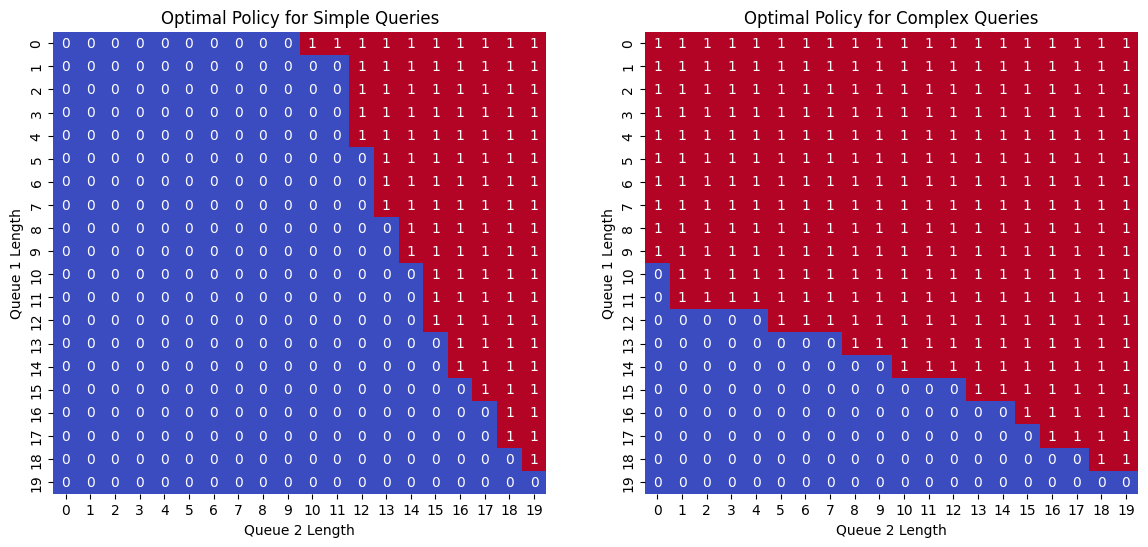

In [37]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(policy_simple, annot=True, cmap="coolwarm", cbar=False, ax=axes[0])
axes[0].set_title("Optimal Policy for Simple Queries")
axes[0].set_xlabel("Queue 2 Length")
axes[0].set_ylabel("Queue 1 Length")

sns.heatmap(policy_complex, annot=True, cmap="coolwarm", cbar=False, ax=axes[1])
axes[1].set_title("Optimal Policy for Complex Queries")
axes[1].set_xlabel("Queue 2 Length")
axes[1].set_ylabel("Queue 1 Length")

plt.show()